In [1]:
%env CUDA_VISIBLE_DEVICES = 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

env: CUDA_VISIBLE_DEVICES=1


In [2]:
df_sr4 = pd.read_csv('../TEST/synthetic_rnn/data_level4.csv')
df_week = pd.read_csv('../TEST/synthetic_rnn/dim_week.csv')
df_lc = pd.read_csv('../TEST/synthetic_rnn/dim_product_lc.csv')

In [3]:
df_sr4 = pd.merge(df_sr4,df_week,on=['week_begin','week_end','week_of_year','week_from_cny',
                                     'dayOff'],how='inner')

In [4]:
df_sr4 = pd.merge(df_sr4,df_lc,on=['LC','product','sub_category','category','temp','off_on_ratio'],how='inner',suffixes='lr')

In [5]:
import datetime
df_sr4.week_begin = pd.to_datetime(df_sr4.week_begin)
df_sr4.week_end = pd.to_datetime(df_sr4.week_end)

In [6]:
ENC_COL = ['week_from_cny',
 'off_on_ratio','week_of_year',
 'holiday_effect_noncny',
 'is_cny']

In [7]:
SR_FEATURE = [ 'sr','same_product_event_sr',
 'same_subcategory_event_sr',
 'same_category_event_sr',]

In [8]:
FEATURE = SR_FEATURE+ENC_COL

In [9]:
df_sr4.head()

,LC,product,temp,category,sub_category,off_on_ratio,week_begin,week_end,week_of_year,week_from_cny,dayOff,week_ind,sr,holiday_effect_noncny,with_mobile_coupon,same_product_event_sr,same_subcategory_event_sr,same_category_event_sr,is_cny,sr_level
0,0,0,hot,3,10,0.974063,2015-01-05,2015-01-11,2,0,2,0,30.082227,1.0,0.0,0.0,0.0,0.000000,0,7.919103
1,0,0,hot,3,10,0.974063,2015-01-12,2015-01-18,3,0,2,1,29.812660,1.0,0.0,0.0,0.0,0.000000,0,7.919103
2,0,0,hot,3,10,0.974063,2015-01-19,2015-01-25,4,0,2,2,29.237116,1.0,0.0,0.0,0.0,38.057621,0,7.919103
3,0,0,hot,3,10,0.974063,2015-01-26,2015-02-01,5,1,2,3,28.814277,1.0,0.0,0.0,0.0,38.057621,0,7.919103
4,0,0,hot,3,10,0.974063,2015-02-02,2015-02-08,6,2,2,4,28.387729,1.0,0.0,0.0,0.0,38.057621,0,7.919103


In [10]:
def split_train_test(df_all,input_sequence_length,pred_length,week_length=156,lag=1): 
    #### Input data formatting   
    date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_all.week_begin[0:week_length]]),
                              data=[i for i in range(len(df_all.week_begin[0:week_length]))])
    train_last_week_begin = date_to_index.index[0]
    test_last_week_begin = week_length - pred_length - input_sequence_length - lag

    val_last_week_end = week_length - pred_length - lag
    val_last_week_begin = val_last_week_end - pred_length - input_sequence_length -lag
    
    train_last_week_end = val_last_week_end - pred_length - lag
    
    train_time_split = date_to_index.index[train_last_week_end]
    test_time_split = date_to_index.index[test_last_week_begin]   
    val_time_split_begin = date_to_index.index[val_last_week_begin]   
    val_time_split_end = date_to_index.index[val_last_week_end] 
    
    train = df_all[df_all['week_begin']<=pd.to_datetime(train_time_split)]
    test = df_all[df_all['week_begin']>=pd.to_datetime(test_time_split)]
    val = df_all[(df_all['week_begin']>=pd.to_datetime(val_time_split_begin))&
                (df_all['week_begin']<=pd.to_datetime(val_time_split_end))]

    return train,test,val

In [17]:
ENC_LENGTH = 18*4
PRED_LENGTH = 18
#fea_num = len(FEATURE_COL)
BATCH_SIZE = 128
whole_ts = PRED_LENGTH+ENC_LENGTH
TRAIN,TEST,VAL = split_train_test(df_sr4,ENC_LENGTH,PRED_LENGTH)

In [12]:
print('Period of train data is from:{} to:{}'.format(np.min(TRAIN.week_begin),np.max(TRAIN.week_begin)))
print('Period of test data is from:{} to:{}'.format(np.min(TEST.week_begin),np.max(TEST.week_begin)))
print('Period of val data is from:{} to:{}'.format(np.min(VAL.week_begin),np.max(VAL.week_begin)))

Period of train data is from:2015-01-05 00:00:00 to:2017-04-10 00:00:00
Period of test data is from:2016-04-04 00:00:00 to:2017-12-25 00:00:00
Period of val data is from:2015-11-23 00:00:00 to:2017-08-21 00:00:00


In [48]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
enc = OneHotEncoder()
f_mtx = df_sr4[FEATURE].iloc[:,1:]
f_in = np.array(f_mtx)[:,(len(SR_FEATURE)-1):]
t_enc = enc.fit(f_in)

In [124]:
len(TRAIN_FEATURE_DATA)

39962

In [73]:
def get_feature_num(df_sample):
    #std_feature = StandardScaler.fit_transform(feature_mtx)
    enc_mtx = enc.transform(df_sample).toarray()
    return (enc_mtx.shape[1]+len(SR_FEATURE))

In [64]:
def get_ts_info(df):
    df_group = df.groupby(['LC','product'])
    feature_data = []
    sr_data = []
    for i in df_group:
        # print(s_data.shape)
        s_sample = i[1].sort_values(by=['week_begin'],ascending=True)
        row = i[1].shape[0]
        for j in range(0,row-whole_ts,1):
            x_col = s_sample.iloc[j:(j+whole_ts)][FEATURE]
            x = x_col.iloc[:,1:]
            y = x_col.iloc[:,0]
            feature_data.append(x.values)
            sr_data.append(y.values)
    return feature_data,sr_data

In [18]:
TRAIN_FEATURE_DATA,TRAIN_SR_DATA = get_ts_info(TRAIN)
VAL_FEATURE_DATA,VAL_SR_DATA = get_ts_info(VAL)

In [21]:
TRAIN_FEATURE_DATA[0].shape

(90, 8)

In [65]:
def get_batch_matrix(feature_list,sr_list,index,input_sequence_length,target_sequence_length):
    ############## get time series data #################
    whole = input_sequence_length+target_sequence_length
    TS_mean = []
    X = sr_list[index]
    X = np.log1p(X)
    ts_mean = X.mean()
    TS_mean.append(ts_mean)
    X = X/ts_mean
    #X_input = X[:input_sequence_length]
    Y = X[input_sequence_length:]
    
    feature = get_feature_mtx(feature_list[index],len(SR_FEATURE)-1)
    # f = get_enc_data(feature)
    # other_features = df[SR_FEATURE][:whole]
    # feature = np.hstack([stable_features,other_features])
    #Y_feature = np.hstack([df[ENC_COL][input_sequence_length:],df[SR_FEATURE][input_sequence_length:]])
    return X,feature,Y,TS_mean

In [133]:
def get_feature_mtx(x,f_start):
    #print(x[:,f_start:].shape)
    mtx = enc.transform(x[:,f_start:]).toarray()
    #print(mtx.shape)
    data = np.concatenate([x[:,:f_start],mtx],axis=1)
    return data

In [67]:
def get_ts_matrix(df,input_sequence_length,target_sequence_length):
    ############## get time series data #################
    whole = input_sequence_length+target_sequence_length
    TS_mean = []
    X = df[:whole,0]
    X = np.log1p(X)
    ts_mean = X.mean()
    TS_mean.append(ts_mean)
    X = X/ts_mean
    Y = df[:input_sequence_length,0]
    
    feature = df[:whole,1:]
    # other_features = df[SR_FEATURE][:whole]
    # feature = np.hstack([stable_features,other_features])
    #Y_feature = np.hstack([df[ENC_COL][input_sequence_length:],df[SR_FEATURE][input_sequence_length:]])
    return X,feature,Y,TS_mean

def get_teaching_force(feature_col,encoder_input,decoder_output):
    decoder_input_train = np.zeros((decoder_output.shape[0], decoder_output.shape[1],feature_col))
    # decoder_output = 
    # X,feature,Y= get_ts_matrix(df,decoder_output.shape[0], decoder_output.shape[1])
    #decode_input_train= np.zeros((20000,18,fea_len))
    decoder_input_train[:,1:,:] = decoder_output[:,:-1,:]
    decoder_input_train[:,0,:] = encoder_input[:,-1,:]
    return decoder_input_train

In [118]:
ss = TRAIN_FEATURE_DATA[10001][:,3:]

In [125]:
FEATURE_LENGTH = get_feature_num(ss)-1

In [126]:
FEATURE_LENGTH

68

In [139]:
from matplotlib import pyplot as plt
import random

batch_size = 128
def data_generator(feature_list,sr_list,batch_size, steps_per_epoch,feature_num,
                input_sequence_length, target_sequence_length,seed=43,steps=1):
    whole_ts_length = input_sequence_length + target_sequence_length
    
    while True:
        np.random.seed(seed)
        for _ in range(steps_per_epoch):
            # Number of batches of size batch_size produced by generator.
            # start_index = 0
            data = np.zeros((batch_size,whole_ts_length,feature_num))
            
            start_index_list = random.sample(range(0,len(feature_list)),batch_size)
           
            for batch_num in range(batch_size):
                # sample_data = df[(df['LC']==lc_list[batch_num])&df['product']==product_list[batch_num]].sort_values(by=['week_begin'],ascending=True)
                index_list = random.sample(range(0,len(feature_list)),batch_size)
                # batch = df[start_index_list[batch_num]:start_index_list[batch_num]+whole_ts_length]
                # print(index_list[batch_num])
                x_whole,feature,y,ts_mean_list = get_batch_matrix(feature_list,sr_list,index_list[batch_num],
                                                                  ENC_LENGTH,PRED_LENGTH)
                # encode_feature,feature_dim = get_encode_mtx(feature[:,:len(ENC_COL)],feature[:,len(ENC_COL):])
                # print(feature.shape)
            
                #print(data[0,:,0])
                for i in range(whole_ts_length):
                    data[batch_num,i,:] = feature[i]
                data[batch_num,:,0] = x_whole
                
            
            encoder_input = data[:,:input_sequence_length,:]
            decoder_output = np.expand_dims(data[:,input_sequence_length:,0],axis=2)
            '''
            The output of the generator must be ([encoder_input, decoder_input], [decoder_output])
            add teaching force to prepare data for training
            '''
            decoder_input = get_teaching_force(feature_num,encoder_input,
                                               data[:,input_sequence_length:,:])
                                                                        
            train_input = np.concatenate([encoder_input, decoder_input], axis=1)
            
            yield (train_input, decoder_output)

In [356]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate,Activation,BatchNormalization,SpatialDropout1D
from keras.optimizers import Adam,rmsprop

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(9)] 
epochs = 200
batch_size = 128
val_batch_size = 64
steps_per_epoch = 500

In [128]:
# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, FEATURE_LENGTH))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

In [129]:
x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 18 time steps as the training target
def slice(x, PRED_LENGTH):
    return x[:,-PRED_LENGTH:,:]

In [130]:
pred_seq_train = Lambda(slice, arguments={'PRED_LENGTH':18})(x)

model = Model(history_seq, pred_seq_train)

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 68)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          4384      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          2080      
__________

In [363]:
# lagging_force
# fea_len = 576
from keras import optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
import keras.backend as kb
#import CLR

earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, 
    verbose=1, mode='auto', epsilon=None)
'''
# drop-cyclic lr schedule - DIY trainning period
def step_decay(epochs):
    initial_lr = 0.0005 
    period = 15
    drop = 0.5
    lr = initial_lr*math.pow(drop, math.floor((1+epochs)/period))
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
lr_scheduler = CLR.CyclicLR(base_lr=0.0005, max_lr=0.002,
                        step_size=200., mode='triangular2')
'''
callbacks = [earlystopping,lr_reducer]

rmsprop = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None, decay=1e-9)
d_model.compile(rmsprop, loss='mean_absolute_error')

train_data_generator = data_generator(TRAIN_FEATURE_DATA,TRAIN_SR_DATA,batch_size=batch_size,
                                   steps_per_epoch=steps_per_epoch,
                                      feature_num = FEATURE_LENGTH,
                                   input_sequence_length=ENC_LENGTH,
                                   target_sequence_length=PRED_LENGTH,
                                    seed=100)
val_data_generator = data_generator(VAL_FEATURE_DATA,VAL_SR_DATA,batch_size=val_batch_size,
                                   steps_per_epoch=steps_per_epoch,
                                      feature_num = FEATURE_LENGTH,
                                   input_sequence_length=ENC_LENGTH,
                                   target_sequence_length=PRED_LENGTH,
                                    seed=43)
#kb.clear_session()
history = d_model.fit_generator(train_data_generator, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_data_generator,
                             validation_steps=50)

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/200
500/500 [==============================] - 131s 263ms/step - loss: 0.9995 - val_loss: 0.2270
Epoch 2/200
500/500 [==============================] - 125s 250ms/step - loss: 0.2191 - val_loss: 0.2167
Epoch 3/200
500/500 [==============================] - 124s 249ms/step - loss: 0.2146 - val_loss: 0.2204
Epoch 4/200
500/500 [==============================] - 126s 251ms/step - loss: 0.2091 - val_loss: 0.1856
Epoch 5/200
500/500 [==============================] - 123s 246ms/step - loss: 0.1611 - val_loss: 0.1478
Epoch 6/200
500/500 [==============================] - 124s 248ms/step - loss: 0.1424 - val_loss: 0.1232
Epoch 7/200
500/500 [==============================] - 126s 252ms/step - loss: 0.1334 - val_loss: 0.1174
Epoch 8/200
500/500 [==============================] - 126s 253ms/step - loss: 0.1280 - val_loss: 0.1459
Epoch 9/200
500/500 [==============================] - 126s 251ms/step - loss: 0.1243 - val_loss: 0.1190
Epoch 10/200
500/500 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 125s 251ms/step - loss: 0.1072 - val_loss: 0.0998
Epoch 18/200
500/500 [==============================] - 124s 249ms/step - loss: 0.1086 - val_loss: 0.1065
Epoch 19/200
500/500 [==============================] - 125s 251ms/step - loss: 0.1071 - val_loss: 0.1031
Epoch 20/200
500/500 [==============================] - 124s 249ms/step - loss: 0.1061 - val_loss: 0.1227
Epoch 21/200
500/500 [==============================] - 125s 251ms/step - loss: 0.1041 - val_loss: 0.1073
Epoch 22/200
500/500 [==============================] - 125s 250ms/step - loss: 0.1052 - val_loss: 0.0959
Epoch 23/200
500/500 [==============================] - 124s 249ms/step - loss: 0.1053 - val_loss: 0.0974
Epoch 24/200
500/500 [==============================] - 124s 248ms/step - loss: 0.1039 - val_loss: 0.1130
Epoch 25/200
500/500 [==============================] - 125s 251ms/step - loss: 0.1028 - val_loss: 0.1012
Epoch 26/200
252/500 [==============>...............] - ETA

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 122s 244ms/step - loss: 0.1023 - val_loss: 0.1118
Epoch 29/200
500/500 [==============================] - 123s 246ms/step - loss: 0.1015 - val_loss: 0.1314
Epoch 30/200
500/500 [==============================] - 124s 248ms/step - loss: 0.1012 - val_loss: 0.1134
Epoch 31/200
500/500 [==============================] - 122s 243ms/step - loss: 0.1014 - val_loss: 0.1044
Epoch 32/200
500/500 [==============================] - 124s 249ms/step - loss: 0.1001 - val_loss: 0.1247
Epoch 33/200
500/500 [==============================] - 123s 246ms/step - loss: 0.1003 - val_loss: 0.1073
Epoch 34/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0998 - val_loss: 0.1046
Epoch 35/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0991 - val_loss: 0.1012
Epoch 36/200
500/500 [==============================] - 123s 245ms/step - loss: 0.1008 - val_loss: 0.1030
Epoch 37/200
500/500 [==============================] - 126

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 126s 252ms/step - loss: 0.0990 - val_loss: 0.1140
Epoch 42/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0979 - val_loss: 0.1120
Epoch 43/200
500/500 [==============================] - 122s 245ms/step - loss: 0.0994 - val_loss: 0.1075
Epoch 44/200
500/500 [==============================] - 123s 247ms/step - loss: 0.0990 - val_loss: 0.1144
Epoch 45/200
500/500 [==============================] - 123s 245ms/step - loss: 0.0986 - val_loss: 0.1074
Epoch 46/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0975 - val_loss: 0.1209
Epoch 47/200
334/500 [===================>..........] - ETA: 37s - loss: 0.0983

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 122s 245ms/step - loss: 0.0975 - val_loss: 0.1081
Epoch 50/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0985 - val_loss: 0.1336
Epoch 51/200
500/500 [==============================] - 122s 243ms/step - loss: 0.0965 - val_loss: 0.1059
Epoch 52/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0976 - val_loss: 0.1119
Epoch 53/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0970 - val_loss: 0.1078
Epoch 54/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0972 - val_loss: 0.1036
Epoch 55/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0977 - val_loss: 0.1056
Epoch 56/200
500/500 [==============================] - 126s 251ms/step - loss: 0.0974 - val_loss: 0.1114
Epoch 57/200
105/500 [=====>........................] - ETA: 1:24 - loss: 0.0955

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 126s 252ms/step - loss: 0.0962 - val_loss: 0.1068
Epoch 60/200
500/500 [==============================] - 126s 251ms/step - loss: 0.0963 - val_loss: 0.1262
Epoch 61/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0971 - val_loss: 0.1097
Epoch 62/200
500/500 [==============================] - 124s 247ms/step - loss: 0.0977 - val_loss: 0.1102
Epoch 63/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0961 - val_loss: 0.1054
Epoch 64/200
500/500 [==============================] - 127s 253ms/step - loss: 0.0955 - val_loss: 0.1032
Epoch 65/200
120/500 [======>.......................] - ETA: 1:21 - loss: 0.0965

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 125s 251ms/step - loss: 0.0956 - val_loss: 0.1051
Epoch 68/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0960 - val_loss: 0.1085
Epoch 69/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0953 - val_loss: 0.1047
Epoch 70/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0959 - val_loss: 0.1103
Epoch 71/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0950 - val_loss: 0.1078
Epoch 72/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0958 - val_loss: 0.1004
Epoch 73/200
500/500 [==============================] - 126s 253ms/step - loss: 0.0955 - val_loss: 0.1268
Epoch 74/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0962 - val_loss: 0.1284
Epoch 75/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0941 - val_loss: 0.1040
Epoch 76/200
500/500 [==============================] - 125

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 126s 251ms/step - loss: 0.0949 - val_loss: 0.1093
Epoch 81/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0944 - val_loss: 0.1275
Epoch 82/200
500/500 [==============================] - 124s 247ms/step - loss: 0.0941 - val_loss: 0.1186
Epoch 83/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0941 - val_loss: 0.1101
Epoch 84/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0939 - val_loss: 0.1090
Epoch 85/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0947 - val_loss: 0.1129
Epoch 86/200
108/500 [=====>........................] - ETA: 1:24 - loss: 0.0953

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 122s 245ms/step - loss: 0.0949 - val_loss: 0.1212
Epoch 89/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0933 - val_loss: 0.1183
Epoch 90/200
500/500 [==============================] - 127s 253ms/step - loss: 0.0945 - val_loss: 0.1273
Epoch 91/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0935 - val_loss: 0.1128
Epoch 92/200
500/500 [==============================] - 128s 255ms/step - loss: 0.0942 - val_loss: 0.1102
Epoch 93/200
500/500 [==============================] - 126s 251ms/step - loss: 0.0924 - val_loss: 0.1056
Epoch 94/200
137/500 [=======>......................] - ETA: 1:18 - loss: 0.0949

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 122s 244ms/step - loss: 0.0938 - val_loss: 0.1124
Epoch 97/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0945 - val_loss: 0.1074
Epoch 98/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0950 - val_loss: 0.1124
Epoch 99/200
500/500 [==============================] - 122s 245ms/step - loss: 0.0930 - val_loss: 0.0999
Epoch 100/200
500/500 [==============================] - 123s 245ms/step - loss: 0.0933 - val_loss: 0.1065
Epoch 101/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0945 - val_loss: 0.1050
Epoch 102/200
500/500 [==============================] - 122s 243ms/step - loss: 0.0939 - val_loss: 0.1266
Epoch 103/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0930 - val_loss: 0.1199
Epoch 104/200
500/500 [==============================] - 126s 253ms/step - loss: 0.0927 - val_loss: 0.1060
Epoch 105/200
187/500 [==========>...................]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 124s 248ms/step - loss: 0.0928 - val_loss: 0.1058
Epoch 108/200
500/500 [==============================] - 127s 254ms/step - loss: 0.0933 - val_loss: 0.1004
Epoch 109/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0931 - val_loss: 0.1093
Epoch 110/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0929 - val_loss: 0.1174
Epoch 111/200
500/500 [==============================] - 124s 247ms/step - loss: 0.0937 - val_loss: 0.1073
Epoch 112/200
500/500 [==============================] - 127s 254ms/step - loss: 0.0939 - val_loss: 0.1121
Epoch 113/200
214/500 [===========>..................] - ETA: 1:04 - loss: 0.0916

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 126s 253ms/step - loss: 0.0935 - val_loss: 0.1100
Epoch 116/200
500/500 [==============================] - 126s 251ms/step - loss: 0.0929 - val_loss: 0.1310
Epoch 117/200
500/500 [==============================] - 126s 253ms/step - loss: 0.0937 - val_loss: 0.1038
Epoch 118/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0928 - val_loss: 0.1091
Epoch 119/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0931 - val_loss: 0.1329
Epoch 120/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0919 - val_loss: 0.1120
Epoch 121/200
246/500 [=============>................] - ETA: 57s - loss: 0.0923

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 122s 243ms/step - loss: 0.0929 - val_loss: 0.1210
Epoch 124/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0932 - val_loss: 0.0994
Epoch 125/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0937 - val_loss: 0.1049
Epoch 126/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0938 - val_loss: 0.1211
Epoch 127/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0933 - val_loss: 0.1193
Epoch 128/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0914 - val_loss: 0.1072
Epoch 129/200
278/500 [===============>..............] - ETA: 48s - loss: 0.0930

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 122s 245ms/step - loss: 0.0928 - val_loss: 0.1183
Epoch 132/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0925 - val_loss: 0.1135
Epoch 133/200
500/500 [==============================] - 122s 243ms/step - loss: 0.0927 - val_loss: 0.1069
Epoch 134/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0923 - val_loss: 0.1224
Epoch 135/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0920 - val_loss: 0.1178
Epoch 136/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0917 - val_loss: 0.1104
Epoch 137/200
500/500 [==============================] - 126s 253ms/step - loss: 0.0918 - val_loss: 0.1139
Epoch 138/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0933 - val_loss: 0.1057
Epoch 139/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0924 - val_loss: 0.1201
Epoch 140/200
226/500 [============>...............

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 122s 245ms/step - loss: 0.0927 - val_loss: 0.1113
Epoch 143/200
500/500 [==============================] - 122s 243ms/step - loss: 0.0922 - val_loss: 0.1140
Epoch 144/200
500/500 [==============================] - 129s 258ms/step - loss: 0.0928 - val_loss: 0.1189
Epoch 145/200
500/500 [==============================] - 126s 253ms/step - loss: 0.0928 - val_loss: 0.1079
Epoch 146/200
500/500 [==============================] - 126s 251ms/step - loss: 0.0920 - val_loss: 0.1107
Epoch 147/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0919 - val_loss: 0.1079
Epoch 148/200
230/500 [============>.................] - ETA: 1:00 - loss: 0.0927

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 125s 250ms/step - loss: 0.0921 - val_loss: 0.1165
Epoch 151/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0927 - val_loss: 0.1086
Epoch 152/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0928 - val_loss: 0.1102
Epoch 153/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0923 - val_loss: 0.1064
Epoch 154/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0921 - val_loss: 0.1135
Epoch 155/200
500/500 [==============================] - 126s 253ms/step - loss: 0.0918 - val_loss: 0.1217
Epoch 156/200
259/500 [==============>...............] - ETA: 53s - loss: 0.0924

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 123s 247ms/step - loss: 0.0916 - val_loss: 0.1106
Epoch 159/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0915 - val_loss: 0.1085
Epoch 160/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0916 - val_loss: 0.1270
Epoch 161/200
500/500 [==============================] - 122s 243ms/step - loss: 0.0926 - val_loss: 0.1151
Epoch 162/200
500/500 [==============================] - 121s 243ms/step - loss: 0.0932 - val_loss: 0.1205
Epoch 163/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0922 - val_loss: 0.1148
Epoch 164/200
261/500 [==============>...............] - ETA: 53s - loss: 0.0912

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 127s 254ms/step - loss: 0.0911 - val_loss: 0.1029
Epoch 167/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0922 - val_loss: 0.1225
Epoch 168/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0919 - val_loss: 0.1176
Epoch 169/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0916 - val_loss: 0.1124
Epoch 170/200
500/500 [==============================] - 127s 255ms/step - loss: 0.0927 - val_loss: 0.1203
Epoch 171/200
500/500 [==============================] - 127s 253ms/step - loss: 0.0913 - val_loss: 0.1200
Epoch 172/200
257/500 [==============>...............] - ETA: 54s - loss: 0.0914

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 125s 249ms/step - loss: 0.0924 - val_loss: 0.1054
Epoch 175/200
500/500 [==============================] - 127s 254ms/step - loss: 0.0915 - val_loss: 0.1354
Epoch 176/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0932 - val_loss: 0.1151
Epoch 177/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0924 - val_loss: 0.1237
Epoch 178/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0916 - val_loss: 0.1232
Epoch 179/200
500/500 [==============================] - 122s 245ms/step - loss: 0.0918 - val_loss: 0.1256
Epoch 180/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0901 - val_loss: 0.1069
Epoch 181/200
500/500 [==============================] - 123s 245ms/step - loss: 0.0916 - val_loss: 0.1121
Epoch 182/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0917 - val_loss: 0.1221
Epoch 183/200
500/500 [============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 123s 245ms/step - loss: 0.0914 - val_loss: 0.1093
Epoch 187/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0927 - val_loss: 0.1140
Epoch 188/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0921 - val_loss: 0.1059
Epoch 189/200
500/500 [==============================] - 123s 247ms/step - loss: 0.0915 - val_loss: 0.1218
Epoch 190/200
500/500 [==============================] - 121s 242ms/step - loss: 0.0911 - val_loss: 0.1091
Epoch 191/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0897 - val_loss: 0.1175
Epoch 192/200
121/500 [======>.......................] - ETA: 1:21 - loss: 0.0902

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 126s 251ms/step - loss: 0.0911 - val_loss: 0.1109
Epoch 195/200
500/500 [==============================] - 123s 246ms/step - loss: 0.0917 - val_loss: 0.1121
Epoch 196/200
500/500 [==============================] - 122s 244ms/step - loss: 0.0917 - val_loss: 0.1341
Epoch 197/200
500/500 [==============================] - 122s 245ms/step - loss: 0.0905 - val_loss: 0.1197
Epoch 198/200
500/500 [==============================] - 123s 245ms/step - loss: 0.0912 - val_loss: 0.1290
Epoch 199/200
500/500 [==============================] - 123s 245ms/step - loss: 0.0915 - val_loss: 0.1095
Epoch 200/200
114/500 [=====>........................] - ETA: 1:20 - loss: 0.0902

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



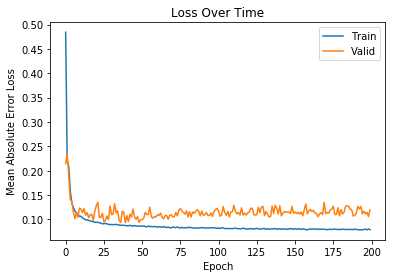

In [286]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [289]:
d_model.save('./base03.h5')
d_model.save_weights('./base03_w.h5')

In [290]:
from keras import models
dd = models.load_model('./base02.h5')

In [291]:
TEST_FEATURE_DATA,TEST_SR_DATA = get_ts_info(TEST)

In [292]:
val_batch_size=64
steps_per_epoch = 500
test_data_generator = data_generator(TEST_FEATURE_DATA,TEST_SR_DATA,batch_size=val_batch_size,
                                   steps_per_epoch=steps_per_epoch,
                                      feature_num = FEATURE_LENGTH,
                                   input_sequence_length=ENC_LENGTH,
                                   target_sequence_length=PRED_LENGTH,
                                    seed=100)

In [293]:
dd.evaluate_generator(test_data_generator,steps=2000,verbose=1)

2000/2000 [==============================] - 220s 110ms/step


0.07494487369246781

In [294]:
def predict_sequence(my_model,datagen,pred_steps=18,sample_size=batch_size):
    pred_seq = np.zeros((sample_size,pred_steps,1))
    iterator = iter(datagen)
    input_sequence = next(iterator)
    target = input_sequence[1]
    x = input_sequence[0]
    for j in range(pred_steps):
        last_pred_step = my_model.predict(x)[:,-1,0]
        #print(last_pred_step.shape)
        pred_seq[:,j,0] = last_pred_step
        #print(input_sequence[0].shape)
        last_step = np.zeros((sample_size,1,FEATURE_LENGTH))
        last_step[:,0,:] = input_sequence[0][:,ENC_LENGTH+j,:]
        last_step[:,0,0] = last_pred_step
        input_ts = np.concatenate([input_sequence[0],last_step],axis=1)
        #print(input_ts.shape)
        x = input_ts
    return pred_seq,target

In [299]:
test_gen = data_generator(TEST_FEATURE_DATA[-1000:],TEST_SR_DATA[-1000:],batch_size=1000,feature_num = FEATURE_LENGTH,
                          steps_per_epoch=steps_per_epoch,
                                   input_sequence_length=ENC_LENGTH,
                                   target_sequence_length=PRED_LENGTH,
                                    seed=30)

In [309]:
predict,target = predict_sequence(dd,test_gen,sample_size=1000)

In [ ]:
####### Results Analysis ############

In [310]:
def weighted_loss_summary(target,test,sample_size):
    single_spot_mape = []
    single_ts_mape= []
    for i in range(sample_size):
        ans,single_loss = cal_sample_weighted_loss(target,test,i)
        single_spot_mape.append(ans)
        single_ts_mape.append(single_loss)
    return single_spot_mape,single_ts_mape

In [311]:
def cal_sample_weighted_loss(target,pred,sample_ind):
    y_real = target[sample_ind,:,0].reshape(-1,1)
    y_pred = pred.reshape(-1,1)
    ans = list(map(lambda x: abs(x[0]-x[1])/x[0],zip(y_real,y_pred)))
    #loss = (y_real-y_pred)/y_real
    loss_w = list(map(lambda x: abs(x[0]-x[1])*abs(x[0]),zip(y_real,y_pred)))
    loss_sr = list(map(lambda x: x[0]**2, y_real))
    loss_sum = sum(loss_w)/sum(loss_sr)
    return ans,loss_sum

In [312]:
ans_mape,weighted_mape = cal_sample_weighted_loss(target,predict,0)

In [313]:
single_spot_mape,single_ts_mape = weighted_loss_summary(target,predict,1000)

In [314]:
mean_spot_mape = np.mean(single_spot_mape)
max_spot_mape = np.max(single_spot_mape)
min_spot_mape = np.min(single_spot_mape)

In [315]:
spot_weighted_mape = pd.DataFrame(single_spot_mape,columns=range(18))

In [316]:
ts_mape_array = np.array(single_spot_mape)

In [317]:
x = ts_mape_array.reshape((1000,18))
xmean = x.mean(axis=1)
xmax = x.max(axis=1)
xmin = x.min(axis=1)

In [318]:
mape_info = np.vstack((xmean,xmax))
mape_info = np.vstack((mape_info,xmin))

In [319]:
m = mape_info.transpose()

In [320]:
mape_frame = pd.DataFrame(m,columns=['mean','max','min'])

In [321]:
mape_frame.describe()

,mean,max,min
count,1000.000000,1000.000000,1000.000000
mean,0.325018,0.506290,0.157907
std,1.020810,1.555811,0.576609
min,0.013527,0.027927,0.000003
25%,0.042585,0.087391,0.001783
50%,0.065293,0.148106,0.005728
75%,0.238492,0.419762,0.059909
max,14.118881,25.061394,6.106443


In [322]:
def predict_and_plot(feature_list, sr_list, sample_ind, my_model,enc_tail_len=72,pred_steps=18):
    input_series = get_batch_input(feature_list, sr_list, sample_ind, enc_tail_len, pred_steps)
    pred_series = my_model.predict(input_series)
    
    #input_series = input_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = sr_list[sample_ind][enc_tail_len:].reshape(-1,1)
    # print(target_series.shape)
    pred = (np.mean(sr_list[sample_ind]))*pred_series
    
    encode_series_tail = sr_list[sample_ind][:72].reshape(-1,1)
    # print(encode_series_tail.shape)
    x_encode = enc_tail_len
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [323]:
def get_batch_input(feature_list, sr_list, sample_ind, input_seq_length, pred_length):
    s = np.zeros((1,whole_ts,FEATURE_LENGTH))
    x,feature,y,ts_mean_list = get_batch_matrix(feature_list,sr_list,sample_ind,ENC_LENGTH,PRED_LENGTH)
    for i in range(whole_ts):
        s[0,i,:] = feature[i]
    s[0,:,0] = x
    enc_input = s[:,:ENC_LENGTH,:]
    dec_output = np.expand_dims(s[:,ENC_LENGTH:,0],axis=2)
    dec_input = get_teaching_force(FEATURE_LENGTH,enc_input,s[:,ENC_LENGTH:,:])
    in_data = np.concatenate([enc_input, dec_input], axis=1)
    return in_data

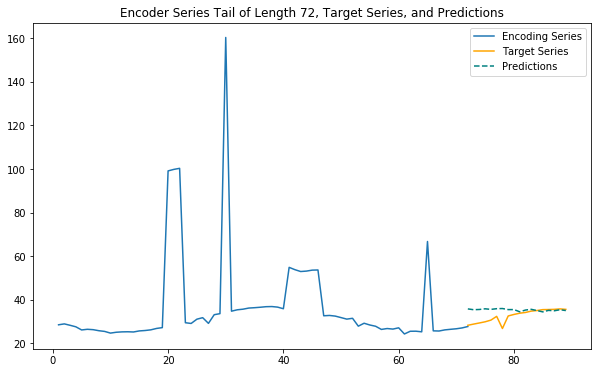

In [329]:
predict_and_plot(TEST_FEATURE_DATA, TEST_SR_DATA,670, dd, enc_tail_len=72,pred_steps=18)

In [273]:
model.save('../base1.h5')
model.save_weights('../base1_w.h5')

In [274]:
from keras import models
t_model = models.load_model('../base1.h5')

In [357]:
################## CNN+dropout/LSTM #####################
'''
seems to be easily overfitting--high val loss and probably skip-out
1st solution: CNN+spatialdropout
2st solution: LSTM wrapped--(attemp to learn better?)
'''
# convolutional layer parameters
from keras.layers import SpatialDropout1D
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 
epochs = 200
batch_size = 128
val_batch_size = 64
steps_per_epoch = 500

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, FEATURE_LENGTH))
x = history_seq
dropout_rate = .2
name = ''

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)
    x = SpatialDropout1D(dropout_rate, name=name + 'spatial_dropout1d_%d_%f' % (dilation_rate*2,dropout_rate))(x)
    
x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 18 time steps as the training target
def slice(x, PRED_LENGTH):
    return x[:,-PRED_LENGTH:,:]

pred_seq_train = Lambda(slice, arguments={'PRED_LENGTH':18})(x)

d_model = Model(history_seq, pred_seq_train)

In [358]:
d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, None, 68)          0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, None, 32)          4384      
_________________________________________________________________
spatial_dropout1d_2_0.200000 (None, None, 32)          0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
spatial_dropout1d_4_0.200000 (None, None, 32)          0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
spatial_dropout1d_8_0.200000 (None, None, 32)          0         
__________

In [359]:
############## Residual Network Added ##################
def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0,name=''):
    # type: (Layer, int, int, str, int, int, float, str) -> Tuple[Layer, Layer]
    original_x = x
    # print('input size-----',original_x.get_shape())
    x = BatchNormalization(axis=-1,name='bn_layer_%d_s%d_%f' % (i, s, dropout_rate))(x)
    x = Activation('linear')(x)
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding)(x)
    x = Activation('linear')(x)    
    x = SpatialDropout1D(dropout_rate, name=name + 'spatial_dropout1d_%d_s%d_%f' % (i*2, s, dropout_rate))(x)
    # print('-----------------2dilate',x.get_shape())
    short_cut = Conv1D(nb_filters, 1, padding='same')(x)
    # 1x1 conv.
    x = Conv1D(nb_filters, 1, padding='same')(x)
    residual_x =add([original_x, x])
    return residual_x,short_cut

In [360]:
############tcn model#################
# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 
epochs = 200
batch_size = 128
val_batch_size = 64
steps_per_epoch = 500
PRED_LENGTH = 18

def my_tcn_model(dilation_rate_range,nb_filters,inputs,padding,n_stacks,kernel_size,
                 dropout_rate,activation,
                 use_skip_connections=True,return_sequences=True):
    # define an input history series and pass it through a stack of dilated causal convolutions. 
    
    x = inputs
    x = Conv1D(filters=nb_filters, padding=padding,dilation_rate=1,kernel_size=filter_width)(x)
    S = []
    for s in range(n_stacks):
        for i in dilation_rate_range:
            x, short_cut = residual_block(x, s, i, activation, n_filters,kernel_size, padding, dropout_rate,activation)
            # print(x.get_shape())
            S.append(short_cut)
    if use_skip_connections:
        skip_connection = add(S)
        x = skip_connection
        
    x = Dense(128, activation='relu')(x)
    x = Dropout(.1)(x)
    x = Dense(1)(x)

    if not return_sequences:
        output_slice_index = -1
        x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
    else:
        x = Lambda(lambda tt: tt[:, -PRED_LENGTH:, :])(x)
    return x

In [361]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate,SpatialDropout1D,add
from keras.optimizers import Adam

history_seq = Input(shape=(None, FEATURE_LENGTH))
x = history_seq

pred_seq_target = my_tcn_model(dilation_rates,n_filters,x,'causal',1,filter_width,.1,'relu')
#pred_no_skip = my_tcn_model(dilation_rates,n_filters,x,'causal',3,filter_width,.1,'relu',use_skip_connections=False)

In [362]:
r_model = Model(history_seq,pred_seq_target)

In [334]:
r_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 68)     0                                            
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, None, 32)     4384        input_9[0][0]                    
__________________________________________________________________________________________________
bn_layer_1_s0_0.100000 (BatchNo (None, None, 32)     128         conv1d_46[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 32)     0           bn_layer_1_s0_0.100000[0][0]     
__________________________________________________________________________________________________
activation

In [335]:
r_model.compile(rmsprop, loss='mean_absolute_error')

history = r_model.fit_generator(train_data_generator, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_data_generator,
                             validation_steps=50)

Epoch 1/200
500/500 [==============================] - 130s 261ms/step - loss: 0.3571 - val_loss: 0.2048
Epoch 2/200
500/500 [==============================] - 124s 248ms/step - loss: 0.2171 - val_loss: 0.1662
Epoch 3/200
500/500 [==============================] - 125s 251ms/step - loss: 0.1579 - val_loss: 0.1201
Epoch 4/200
500/500 [==============================] - 123s 247ms/step - loss: 0.1375 - val_loss: 0.1378
Epoch 5/200
500/500 [==============================] - 123s 246ms/step - loss: 0.1256 - val_loss: 0.1237
Epoch 6/200
500/500 [==============================] - 123s 246ms/step - loss: 0.1172 - val_loss: 0.1152
Epoch 7/200
500/500 [==============================] - 123s 247ms/step - loss: 0.1122 - val_loss: 0.1010
Epoch 8/200
500/500 [==============================] - 125s 250ms/step - loss: 0.1061 - val_loss: 0.0991
Epoch 9/200
500/500 [==============================] - 126s 253ms/step - loss: 0.1026 - val_loss: 0.1087
Epoch 10/200
500/500 [==============================] -

500/500 [==============================] - 124s 248ms/step - loss: 0.0596 - val_loss: 0.0908
Epoch 79/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0595 - val_loss: 0.1006
Epoch 80/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0603 - val_loss: 0.0997
Epoch 81/200
500/500 [==============================] - 126s 251ms/step - loss: 0.0593 - val_loss: 0.1168
Epoch 82/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0596 - val_loss: 0.1074
Epoch 83/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0593 - val_loss: 0.1023
Epoch 84/200
500/500 [==============================] - 124s 248ms/step - loss: 0.0593 - val_loss: 0.0981
Epoch 85/200
500/500 [==============================] - 126s 253ms/step - loss: 0.0594 - val_loss: 0.1071
Epoch 86/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0592 - val_loss: 0.1016
Epoch 87/200
500/500 [==============================] - 125

Epoch 155/200
500/500 [==============================] - 124s 247ms/step - loss: 0.0562 - val_loss: 0.1193
Epoch 156/200
500/500 [==============================] - 126s 252ms/step - loss: 0.0554 - val_loss: 0.1304
Epoch 157/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0557 - val_loss: 0.1194
Epoch 158/200
500/500 [==============================] - 124s 249ms/step - loss: 0.0561 - val_loss: 0.1225
Epoch 159/200
500/500 [==============================] - 126s 251ms/step - loss: 0.0560 - val_loss: 0.1269
Epoch 160/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0554 - val_loss: 0.1188
Epoch 161/200
500/500 [==============================] - 125s 249ms/step - loss: 0.0551 - val_loss: 0.1310
Epoch 162/200
500/500 [==============================] - 125s 250ms/step - loss: 0.0553 - val_loss: 0.1283
Epoch 163/200
500/500 [==============================] - 125s 251ms/step - loss: 0.0553 - val_loss: 0.1234
Epoch 164/200
500/500 [==============

In [353]:
r_model.save('./base04.h5')
r_model.save_weights('./base04_w.h5')

In [355]:
r_model.evaluate_generator(test_data_generator,steps=2000,verbose=1)

2000/2000 [==============================] - 221s 111ms/step


0.0750373397283256